In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from pprint import pprint

from riskslim.helper_functions import load_data_from_csv, print_model
from riskslim.setup_functions import get_conservative_offset
from riskslim.coefficient_set import CoefficientSet
from riskslim.lattice_cpa import run_lattice_cpa
from riskslim.lattice_cpa import setup_lattice_cpa, finish_lattice_cpa

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle

### Modeling -- RiskSLIM

#### Basic Set Up

In [6]:
def risk_slim(data, max_coefficient, max_L0_value, c0_value, max_runtime = 120, w_pos = 1, max_offset=50):
    
    
    """
    @parameters:
    
    max_coefficient:  value of largest/smallest coefficient
    max_L0_value:     maximum model size (set as float(inf))
    max_offset:       maximum value of offset parameter (optional)
    c0_value:         L0-penalty parameter such that c0_value > 0; larger values -> 
                      sparser models; we set to a small value (1e-6) so that we get a model with max_L0_value terms
    max_runtime:      max algorithm running time
    w_pos:            relative weight on examples with y = +1; w_neg = 1.00 (optional)
    
    """
    
    # create coefficient set and set the value of the offset parameter
    coef_set = CoefficientSet(variable_names = data['variable_names'], lb = 0, ub = max_coefficient, sign = 0)
    conservative_offset = get_conservative_offset(data, coef_set, max_L0_value)
    max_offset = min(max_offset, conservative_offset)
    coef_set['(Intercept)'].ub = max_offset
    coef_set['(Intercept)'].lb = -max_offset

    constraints = {
        'L0_min': 0,
        'L0_max': max_L0_value,
        'coef_set':coef_set,
    }
    
    # Set parameters
    settings = {
        # Problem Parameters
        'c0_value': c0_value,
        'w_pos': w_pos,

        # LCPA Settings
        'max_runtime': max_runtime,                         # max runtime for LCPA
        'max_tolerance': np.finfo('float').eps,             # tolerance to stop LCPA (set to 0 to return provably optimal solution)
        'display_cplex_progress': True,                     # print CPLEX progress on screen
        'loss_computation': 'lookup',                       # how to compute the loss function ('normal','fast','lookup')
        
        # LCPA Improvements
        'round_flag': False,                                # round continuous solutions with SeqRd
        'polish_flag': False,                               # polish integer feasible solutions with DCD
        'chained_updates_flag': False,                      # use chained updates
        'add_cuts_at_heuristic_solutions': True,            # add cuts at integer feasible solutions found using polishing/rounding
        
        # Initialization
        'initialization_flag': True,                        # use initialization procedure
        'init_max_runtime': 300.0,                          # max time to run CPA in initialization procedure
        'init_max_coefficient_gap': 0.49,

        # CPLEX Solver Parameters
        'cplex_randomseed': 0,                              # random seed
        'cplex_mipemphasis': 0,                             # cplex MIP strategy
    }
    

    # train model using lattice_cpa
    model_info, mip_info, lcpa_info = run_lattice_cpa(data, constraints, settings)
        
    return model_info, mip_info, lcpa_info

#### advanced

In [3]:
def risk_slim(data, max_coefficient, max_L0_value, c0_value, max_runtime = 120, w_pos = 1, max_offset=50):
    
    
    """
    @parameters:
    
    max_coefficient:  value of largest/smallest coefficient
    max_L0_value:     maximum model size (set as float(inf))
    max_offset:       maximum value of offset parameter (optional)
    c0_value:         L0-penalty parameter such that c0_value > 0; larger values -> 
                      sparser models; we set to a small value (1e-6) so that we get a model with max_L0_value terms
    max_runtime:      max algorithm running time
    w_pos:            relative weight on examples with y = +1; w_neg = 1.00 (optional)
    
    """
    
    # create coefficient set and set the value of the offset parameter
    coef_set = CoefficientSet(variable_names = data['variable_names'], lb = 0, ub = max_coefficient, sign = 0)
    conservative_offset = get_conservative_offset(data, coef_set, max_L0_value)
    max_offset = min(max_offset, conservative_offset)
    coef_set['(Intercept)'].ub = max_offset
    coef_set['(Intercept)'].lb = -max_offset

    constraints = {
        'L0_min': 0,
        'L0_max': max_L0_value,
        'coef_set':coef_set,
    }
    
    # Set parameters
    settings = {
        #
        'c0_value': c0_value,
        'w_pos': w_pos,
        #
        # LCPA Settings
        'max_runtime': max_runtime,                               # max runtime for LCPA
        'max_tolerance': np.finfo('float').eps,             # tolerance to stop LCPA (set to 0 to return provably optimal solution)
        'display_cplex_progress': True,                     # set to True to print CPLEX progress
        'loss_computation': 'lookup',                       # how to compute the loss function ('normal','fast','lookup')
        #
        # Other LCPA Heuristics
        'chained_updates_flag': True,                         # use chained updates
        'add_cuts_at_heuristic_solutions': True,            # add cuts at integer feasible solutions found using polishing/rounding
        #
        # LCPA Rounding Heuristic
        'round_flag': False,                                 # round continuous solutions with SeqRd
        'polish_rounded_solutions': True,                   # polish solutions rounded with SeqRd using DCD
        'rounding_tolerance': float('inf'),                 # only solutions with objective value < (1 + tol) are rounded
        'rounding_start_cuts': 0,                           # cuts needed to start using rounding heuristic
        'rounding_start_gap': float('inf'),                 # optimality gap needed to start using rounding heuristic
        'rounding_stop_cuts': 20000,                        # cuts needed to stop using rounding heuristic
        'rounding_stop_gap': 0.2,                           # optimality gap needed to stop using rounding heuristic
        #
        # LCPA Polishing Heuristic
        'polish_flag': False,                                # polish integer feasible solutions with DCD
        'polishing_tolerance': 0.1,                         # only solutions with objective value (1 + tol) are polished.
        'polishing_max_runtime': 10.0,                      # max time to run polishing each time
        'polishing_max_solutions': 5.0,                     # max # of solutions to polish each time
        'polishing_start_cuts': 0,                          # cuts needed to start using polishing heuristic
        'polishing_start_gap': float('inf'),                # min optimality gap needed to start using polishing heuristic
        'polishing_stop_cuts': float('inf'),                # cuts needed to stop using polishing heuristic
        'polishing_stop_gap': 0.0,                          # max optimality gap required to stop using polishing heuristic
        #
        # Initialization Procedure
        'initialization_flag': True,                       # use initialization procedure
        'init_display_progress': True,                      # show progress of initialization procedure
        'init_display_cplex_progress': False,               # show progress of CPLEX during intialization procedure
        #
        'init_max_runtime': 300.0,                          # max time to run CPA in initialization procedure
        'init_max_iterations': 10000,                       # max # of cuts needed to stop CPA
        'init_max_tolerance': 0.0001,                       # tolerance of solution to stop CPA
        'init_max_runtime_per_iteration': 300.0,            # max time per iteration of CPA
        'init_max_cplex_time_per_iteration': 10.0,          # max time per iteration to solve surrogate problem in CPA
        #
        'init_use_rounding': True,                          # use Rd in initialization procedure
        'init_rounding_max_runtime': 30.0,                  # max runtime for Rd in initialization procedure
        'init_rounding_max_solutions': 5,                   # max solutions to round using Rd
        #
        'init_use_sequential_rounding': True,               # use SeqRd in initialization procedure
        'init_sequential_rounding_max_runtime': 10.0,       # max runtime for SeqRd in initialization procedure
        'init_sequential_rounding_max_solutions': 5,        # max solutions to round using SeqRd
        #
        'init_polishing_after': True,                       # polish after rounding
        'init_polishing_max_runtime': 30.0,                 # max runtime for polishing
        'init_polishing_max_solutions': 5,                  # max solutions to polish
        #
        # CPLEX Solver Parameters
        'cplex_randomseed': 0,                              # random seed
        'cplex_mipemphasis': 0,                             # cplex MIP strategy
    }

    # train model using lattice_cpa
    model_info, mip_info, lcpa_info = run_lattice_cpa(data, constraints, settings)
        
    return model_info, mip_info, lcpa_info

In [7]:
def riskslim_prediction(X, feature_name, model_info):
    
    """
    @parameters
    
    X: test input features (np.array)
    feature_name: feature names
    model_info: output from RiskSLIM model
    
    """
    
    ## initialize parameters
    dictionary = {}
    prob = np.zeros(len(X))
    scores = np.zeros(len(X))
    
    ## prepare statistics
    subtraction_score = model_info['solution'][0]
    coefs = model_info['solution'][1:]
    index = np.where(coefs != 0)[0]
    
    nonzero_coefs = coefs[index]
    features = feature_name[index]
    X_sub = X[:,index]
    
    ## build dictionaries
    for i in range(len(features)):
        single_feature = features[i]
        coef = nonzero_coefs[i]
        dictionary.update({single_feature: coef})
        
    ## calculate probability
    for i in range(len(X_sub)):
        summation = 0
        for j in range(len(features)):
            a = X_sub[i,j]
            summation += dictionary[features[j]] * a
        scores[i] = summation
    
    prob = 1/(1+np.exp(-(scores + subtraction_score)))
    
    return prob

In [8]:
def riskslim_accuracy(X, Y, feature_name, model_info, threshold=0.5):
    
    prob = riskslim_prediction(X, feature_name, model_info)
    pred = np.mean((prob > threshold) == Y)
    
    return pred

### Test One Model

#### original data

In [9]:
train = pd.read_csv("C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY models/Models/RiskSLIM/new_train.csv")
test = pd.read_csv("C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY models/Models/RiskSLIM/new_test.csv")

## split features and dependant variable
x_test, y_test = test.iloc[:,1:].values, test.iloc[:,0].values
x_train, y_train = train.iloc[:,1:].values, train.iloc[:,0].values
y_test[y_test == -1] = 0
y_train[y_train == -1] = 0

## column names
cols = train.columns[1:]

In [10]:
len(cols)

123

In [12]:
# data path
data_name = "new_train.csv"          
data_csv_file = os.getcwd() + '/' + data_name 
sample_weights_csv_file = None 
# load data
data = load_data_from_csv(dataset_csv_file = data_csv_file, sample_weights_csv_file = sample_weights_csv_file)

In [13]:
model_info, mip_info, lcpa_info = risk_slim(data, max_coefficient=5, max_L0_value=10, c0_value=1e-5, max_runtime=300)

#model info contains key results
print_model(model_info['solution'], data)

setting c0 = 0.0 to ensure that intercept is not penalized
08/02/19 @ 11:15 AM | 1321 rows in lookup table
08/02/19 @ 11:15 AM | ------------------------------------------------------------
08/02/19 @ 11:15 AM | runnning initialization procedure
08/02/19 @ 11:15 AM | ------------------------------------------------------------
08/02/19 @ 11:15 AM | CPA produced 2 cuts
08/02/19 @ 11:15 AM | running naive rounding on 38 solutions
08/02/19 @ 11:15 AM | best objective value: 0.5225
08/02/19 @ 11:15 AM | rounding produced 5 integer solutions
08/02/19 @ 11:15 AM | best objective value is 0.5345
08/02/19 @ 11:15 AM | running sequential rounding on 38 solutions
08/02/19 @ 11:15 AM | best objective value: 0.5225
08/02/19 @ 11:15 AM | sequential rounding produced 6 integer solutions
08/02/19 @ 11:15 AM | best objective value: 0.5272
08/02/19 @ 11:15 AM | polishing 11 solutions
08/02/19 @ 11:15 AM | best objective value: 0.5272
08/02/19 @ 11:15 AM | polishing produced 5 integer solutions
08/02/19

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
08/02/19 @ 11:15 AM | adding 333 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.5272.
Tried aggregator 1 time.
Reduced MIP has 125 rows, 250 columns, and 495 nonzeros.
Reduced MIP has 123 binaries, 125 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.24 ticks)
Probing time = 0.00 sec. (0.19 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.16 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Va

  69845 36376        0.5241    13        0.5260        0.5102   470858    3.01%         rho_107 D  69845  69843    111
  71099 36994        0.5102    15        0.5260        0.5102   479841    3.01%          rho_76 D  71099  71098     68
  72376 37698        0.5188    13        0.5260        0.5102   488978    3.01%          rho_69 D  72376  72375     87
  73672 38319        0.5102     8        0.5260        0.5102   497012    3.01%          rho_19 U  73672  73670     55
  74974 38939        0.5202    15        0.5260        0.5102   505419    3.01%           rho_0 U  74974  74973     52
  76368 39558        0.5246    14        0.5260        0.5102   516950    3.01%          rho_83 D  76368  76366     65
  77985 40371        0.5226    13        0.5260        0.5102   526950    3.01%           rho_0 U  77985  77984     60
  79432 41026        cutoff              0.5260        0.5102   538508    3.01%          rho_83 U  79432  79431     72
  80970 41935        cutoff              0.5260 

 234725 120602        0.5226    17        0.5260        0.5102  1678471    3.01%         rho_100 U 234725 234724     65
 239250 122887        0.5116    25        0.5260        0.5102  1724486    3.01%           rho_4 D 239250 239249     71
 244373 125368        cutoff              0.5260        0.5102  1773427    3.01%          rho_52 U 244373 244371     62
 250000 127793        0.5177    20        0.5260        0.5102  1824575    3.01%          rho_63 D 250000 249999     63
Elapsed time = 85.81 sec. (168167.78 ticks, tree = 51.07 MB, solutions = 3)
 255361 129780        cutoff              0.5260        0.5102  1874348    3.01%          rho_83 U 255361 255360     81
 260625 131893        0.5102     1        0.5260        0.5102  1925300    3.01%          rho_19 U 260625 260623     59
 266185 134747        0.5102    19        0.5260        0.5102  1970771    3.01%          rho_83 D 266185 266184     66
 270973 136976        0.5120    24        0.5260        0.5102  2013963    3.01%    

 529027 268654        0.5246    18        0.5260        0.5102  4276223    3.00%          rho_83 U 529027 529026     59
 534251 271022        0.5251    17        0.5260        0.5102  4330337    3.00%         rho_123 D 534251 534249     67
 539223 273353        cutoff              0.5260        0.5102  4381877    3.00%           rho_0 U 539223 539221     76
 543918 275810        0.5156    26        0.5260        0.5102  4428644    3.00%          rho_61 D 543918 543917     79
Elapsed time = 192.44 sec. (397099.07 ticks, tree = 116.24 MB, solutions = 9)
 548002 277930        0.5227    19        0.5260        0.5102  4473106    3.00%         rho_104 D 548002 548000    104
 552167 280038        cutoff              0.5260        0.5102  4517657    3.00%           rho_0 U 552167 552166     52
 556956 282537        cutoff              0.5260        0.5102  4561161    3.00%           rho_3 U 556956 556953     83
 561023 284687        0.5170    27        0.5260        0.5102  4601552    3.00%  

In [14]:
train_prob = riskslim_prediction(x_train, cols, model_info)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, train_prob)
holdout_train_auc = auc(train_fpr, train_tpr)
holdout_train_auc

0.7067039412236545

In [15]:
test_prob = riskslim_prediction(x_test, cols, model_info)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, test_prob)
holdout_test_auc = auc(test_fpr, test_tpr)
holdout_test_auc

0.7034673163896548

#### Compare with Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV, cross_validate

In [17]:
## cross validation set up
inner_cv = KFold(n_splits=5,shuffle=True,random_state=816)
outer_cv = KFold(n_splits=5,shuffle=True,random_state=816)
   
### model & parameters
lr = LogisticRegression(class_weight = 'balanced', solver='liblinear', random_state=816)
c_grid = {"C": [1e-4, 1e-3, 1e-2, 0.1,1]}

In [ ]:
### nested cross validation
clf = GridSearchCV(estimator=lr, param_grid=c_grid, scoring='roc_auc',cv=inner_cv, return_train_score=True)
nested_score = cross_validate(clf, X=x_train, y=y_train, scoring='roc_auc', cv=outer_cv, return_train_score=True)
train_score, test_score = nested_score['train_score'], nested_score['test_score']
np.mean(train_score) - np.mean(test_score), np.mean(test_score)

### Cross Validation

In [38]:
# data path
data_name = "new_train.csv"          
data_csv_file = os.getcwd() + '/' + data_name 
sample_weights_csv_file = None 

# load data
data = load_data_from_csv(dataset_csv_file = data_csv_file, sample_weights_csv_file = sample_weights_csv_file)
X, Y = data['X'], data['Y']
variable_names = data['variable_names']
outcome_name = data['outcome_name']
sample_weights = data['sample_weights']

c:\users\binha\risk-slim\riskslim\helper_functions.py:215: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  raw_data = df.as_matrix()


In [39]:
#cv = KFold(n_splits=5, random_state=816, shuffle=True)
cv = StratifiedKFold(n_splits=5, random_state=816, shuffle=True)
train_acc, test_acc = [], []
train_auc, test_auc = [], []

i = 0
for train, test in cv.split(X, Y):
    
    ## subset train data & store test data
    X_train, Y_train = X[train], Y[train]
    X_test, Y_test = X[test], Y[test]
    sample_weights_train, sample_weights_test = sample_weights[train], sample_weights[test]

    ## create new data dictionary
    new_train_data = {
        'X': X_train,
        'Y': Y_train,
        'variable_names': variable_names,
        'outcome_name': outcome_name,
        'sample_weights': sample_weights_train
    }
        
    ## fit the model
    model_info, mip_info, lcpa_info = risk_slim(new_train_data, 
                                                max_coefficient=5, 
                                                max_L0_value=10, 
                                                c0_value=5e-5, max_runtime=200)
    print_model(model_info['solution'], new_train_data)
    
    ## change data format
    X_train, X_test = X_train[:,1:], X_test[:,1:] ## remove the first column, which is "intercept"
    Y_train[Y_train == -1] = 0 ## change -1 to 0
    Y_test[Y_test == -1] = 0
    
    ## probability & accuracy
    train_prob = riskslim_prediction(X_train, cols, model_info).reshape(-1,1)
    test_prob = riskslim_prediction(X_test, cols, model_info).reshape(-1,1)
    
    train_acc.append(np.mean((train_prob > 0.5) == Y_train))
    test_acc.append(np.mean((test_prob > 0.5) == Y_test))
    
    ## AUC
    train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, train_prob)
    test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, test_prob)    
    train_auc.append(auc(train_fpr, train_tpr))
    test_auc.append(auc(test_fpr, test_tpr))

setting c0 = 0.0 to ensure that intercept is not penalized
07/15/19 @ 10:24 PM | switching loss computation from normal to lookup
07/15/19 @ 10:24 PM | 1631 rows in lookup table
07/15/19 @ 10:24 PM | ------------------------------------------------------------
07/15/19 @ 10:24 PM | runnning initialization procedure
07/15/19 @ 10:24 PM | ------------------------------------------------------------
07/15/19 @ 10:24 PM | CPA produced 2 cuts
07/15/19 @ 10:24 PM | running naive rounding on 1 solutions
07/15/19 @ 10:24 PM | best objective value: 0.7672
07/15/19 @ 10:24 PM | rounding produced 1 integer solutions
07/15/19 @ 10:24 PM | best objective value is 0.7542
07/15/19 @ 10:24 PM | running sequential rounding on 1 solutions
07/15/19 @ 10:24 PM | best objective value: 0.7672
07/15/19 @ 10:24 PM | sequential rounding produced 1 integer solutions
07/15/19 @ 10:24 PM | best objective value: 0.7542
07/15/19 @ 10:24 PM | polishing 2 solutions
07/15/19 @ 10:24 PM | best objective value: 0.7542
0

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
07/15/19 @ 10:24 PM | adding 383 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.7542.
Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 2 columns.
MIP Presolve modified 155 coefficients.
Reduced MIP has 156 rows, 312 columns, and 465 nonzeros.
Reduced MIP has 155 binaries, 156 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.39 ticks)
Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.18 ticks)

        Nodes                                         Cuts/
   

Elapsed time = 72.53 sec. (91971.16 ticks, tree = 14.06 MB, solutions = 30)
  52534 28722        0.5252    18        0.5387        0.5210   456103    3.29%          rho_13 D  52534  52532     84
  54010 29476        0.5210     9        0.5387        0.5210   471472    3.29%          rho_23 D  54010  54009     47
  55430 30144        0.5210    23        0.5387        0.5210   487676    3.29%          rho_31 U  55430  55429     49
  56920 30802        0.5347     1        0.5387        0.5210   502368    3.29%          rho_58 U  56920  56917     64
  58400 31422        0.5210    31        0.5387        0.5210   518842    3.29%           rho_0 D  58400  58398     58
  59950 32120        0.5215    22        0.5387        0.5210   534951    3.29%          rho_98 D  59950  59949     63
  61560 32934        cutoff              0.5387        0.5210   551380    3.29%           rho_6 U  61560  61559     86
  63080 33784        0.5365     6        0.5387        0.5210   569932    3.29%          rh

                          ------------
Total (root+branch&cut) =  200.01 sec. (333154.78 ticks)
+----------------------------------------------+------------------+-----------+
| Pr(Y = +1) = 1.0/(1.0 + exp(-(-2 + score))   |                  |           |
| ============================================ | ================ | ========= |
| p_arrest>=2                                  |         1 points |   + ..... |
| p_arrest>=4                                  |         1 points |   + ..... |
| p_pending_charge>=1                          |         1 points |   + ..... |
| ============================================ | ================ | ========= |
| ADD POINTS FROM ROWS 1 to 3                  |            SCORE |   = ..... |
+----------------------------------------------+------------------+-----------+
setting c0 = 0.0 to ensure that intercept is not penalized
07/15/19 @ 10:27 PM | switching loss computation from normal to lookup
07/15/19 @ 10:27 PM | 1631 rows in lookup table
07/15/

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
07/15/19 @ 10:28 PM | adding 339 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.6130.
Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 2 columns.
MIP Presolve modified 155 coefficients.
Reduced MIP has 156 rows, 312 columns, and 465 nonzeros.
Reduced MIP has 155 binaries, 156 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.39 ticks)
Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.18 ticks)

        Nodes                                         Cuts/
   

  60804 34019        0.5220    18        0.5426        0.5199   514335    4.19%          rho_22 D  60804  60803     64
  62823 35092        0.5329    20        0.5426        0.5199   536247    4.19%          rho_89 D  62823  62822     80
  64831 36225        0.5199     6        0.5426        0.5199   557587    4.19%          rho_24 U  64831  64666     57
  66668 37178        0.5218    13        0.5426        0.5199   576933    4.19%          rho_20 U  66668  66667     61
  68526 38224        0.5208    13        0.5426        0.5199   596236    4.19%         rho_138 D  68526  68525     59
  70304 39229        0.5378    20        0.5426        0.5199   615920    4.19%          rho_11 D  70304  70302     60
  72063 40063        cutoff              0.5426        0.5199   633242    4.19%           rho_0 U  72063  72061     54
  73702 40928        0.5209    25        0.5426        0.5199   651523    4.19%          rho_21 D  73702  16626     58
  75480 41911        0.5199     5        0.5426 

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 2 columns.
MIP Presolve modified 155 coefficients.
Reduced MIP has 156 rows, 312 columns, and 465 nonzeros.
Reduced MIP has 155 binaries, 156 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.39 ticks)
Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.18 ticks)
07/15/19 @ 10:31 PM | adding 319 initial cuts

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variable B NodeID Parent  

  82097 61282        0.5207    36        0.5347        0.5207   690036    2.62%           rho_0 U  82097  82096     34
  84010 62633        0.5300    16        0.5347        0.5207   708736    2.62%          rho_34 U  84010  84009     26
Elapsed time = 86.13 sec. (130506.51 ticks, tree = 202.97 MB, solutions = 16)
  86001 63751        0.5227    14        0.5347        0.5207   723982    2.62%          rho_77 U  86001  86000     75
  87980 64905        0.5325    14        0.5347        0.5207   740658    2.62%          rho_76 D  87980  87979    101
  89912 66297        cutoff              0.5347        0.5207   758822    2.62%           rho_6 U  89912  89910     64
  91910 67667        0.5218    18        0.5347        0.5207   776197    2.62%          rho_31 D  91910  91908     60
  93945 69161        0.5317    12        0.5347        0.5207   794006    2.62%          rho_76 D  93945  93943     95
  96032 70611        0.5237    16        0.5347        0.5207   810878    2.62%         r

07/15/19 @ 10:35 PM | 1631 rows in lookup table
07/15/19 @ 10:35 PM | ------------------------------------------------------------
07/15/19 @ 10:35 PM | runnning initialization procedure
07/15/19 @ 10:35 PM | ------------------------------------------------------------
07/15/19 @ 10:35 PM | CPA produced 2 cuts
07/15/19 @ 10:35 PM | all CPA solutions are infeasible
07/15/19 @ 10:35 PM | initialization produced 0 feasible solutions
07/15/19 @ 10:35 PM | ------------------------------------------------------------
07/15/19 @ 10:35 PM | completed initialization procedure
07/15/19 @ 10:35 PM | ------------------------------------------------------------
07/15/19 @ 10:35 PM | switching loss computation from normal to lookup
07/15/19 @ 10:35 PM | 1631 rows in lookup table
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 1
CPXPARAM_Parallel                                1
CPXPARAM_RandomSeed                              0
CPXPARAM_TimeLimit  

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 2 columns.
MIP Presolve modified 155 coefficients.
Reduced MIP has 156 rows, 312 columns, and 465 nonzeros.
Reduced MIP has 155 binaries, 156 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.39 ticks)
Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.18 ticks)
07/15/19 @ 10:35 PM | adding 354 initial cuts

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variable B NodeID Parent  

  88726 70870        0.5221    23        0.5334        0.5202   685962    2.47%         rho_110 U  88726  60941     23
  90859 72509        0.5210    28        0.5334        0.5203   702815    2.47%         rho_139 D  90859  90858     37
  93140 74370        0.5214    13        0.5334        0.5203   720274    2.47%         rho_103 D  93140  93139     64
Elapsed time = 89.86 sec. (130472.85 ticks, tree = 107.18 MB, solutions = 19)
  95168 75824        0.5297    12        0.5334        0.5203   736515    2.47%         rho_143 D  95168  95167    110
  97420 77580        0.5297    15        0.5334        0.5203   753033    2.47%         rho_143 D  97420  97419     95
  99552 79159        cutoff              0.5334        0.5203   769277    2.47%          rho_66 U  99552  99551    107
 101680 80662        0.5210    28        0.5334        0.5203   785690    2.47%         rho_110 D 101680 101679     19
 103919 82366        0.5273    17        0.5334        0.5203   801820    2.47%          

07/15/19 @ 10:39 PM | best objective value: 0.8973
07/15/19 @ 10:39 PM | rounding produced 1 integer solutions
07/15/19 @ 10:39 PM | best objective value is 0.8279
07/15/19 @ 10:39 PM | running sequential rounding on 1 solutions
07/15/19 @ 10:39 PM | best objective value: 0.8973
07/15/19 @ 10:39 PM | sequential rounding produced 1 integer solutions
07/15/19 @ 10:39 PM | best objective value: 0.8279
07/15/19 @ 10:39 PM | polishing 2 solutions
07/15/19 @ 10:39 PM | best objective value: 0.8279
07/15/19 @ 10:39 PM | polishing produced 1 integer solutions
07/15/19 @ 10:39 PM | initialization produced 2 feasible solutions
07/15/19 @ 10:39 PM | best objective value: 0.7535
07/15/19 @ 10:39 PM | ------------------------------------------------------------
07/15/19 @ 10:39 PM | completed initialization procedure
07/15/19 @ 10:39 PM | ------------------------------------------------------------
07/15/19 @ 10:39 PM | switching loss computation from normal to lookup
07/15/19 @ 10:39 PM | 1631 row

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
07/15/19 @ 10:39 PM | adding 262 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.7535.
Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 2 columns.
MIP Presolve modified 155 coefficients.
Reduced MIP has 156 rows, 312 columns, and 465 nonzeros.
Reduced MIP has 155 binaries, 156 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.39 ticks)
Probing time = 0.00 sec. (0.03 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.18 ticks)

        Nodes                                         Cuts/
   

  84483 53203        0.5192    11        0.5441        0.5192   875910    4.57%          rho_22 D  84483  84482     50
  86538 54380        0.5197    19        0.5441        0.5192   898670    4.57%          rho_14 D  86538  86537     57
  88559 55610        cutoff              0.5441        0.5192   923083    4.57%         rho_111 U  88559  88558     60
  90523 56896        cutoff              0.5441        0.5192   948111    4.57%           rho_0 U  90523  90522     55
  92759 58351        0.5192    11        0.5441        0.5192   972190    4.57%          rho_34 U  92759  92758     55
* 92920+51469                            0.5409        0.5192             4.00%
  95160 53201        0.5401     0        0.5409        0.5192   988297    4.00%         rho_102 D  95160  95158     43
  97432 54693        cutoff              0.5409        0.5192  1004999    4.00%          rho_26 D  97432  97431     47
  99310 55790        0.5373     8        0.5409        0.5192  1022087    4.00%        

In [40]:
np.mean(train_auc), np.std(train_auc), np.mean(test_auc), np.std(test_auc)

(0.7108736257438553,
 0.003055521361742535,
 0.7107420746932377,
 0.004425740446577154)

In [34]:
#log model results to the model performance folder, as per standards
path = "C:\\Users\\binha\\Documents\\Duke\\Cynthia Research\\KY-analysis-mytrials\\KY Recidivism\\KY Results\\Models\\"

train_auc_mean, train_auc_std = np.mean(train_auc), np.std(train_auc)
test_auc_mean, test_auc_std = np.mean(test_auc), np.std(test_auc)
                   
results = [["Model", "train_auc_mean", "train_auc_std", "validation_auc_mean", "validation_auc_std", "holdout_test_auc", "holdout_test_acc"],
    ["RiskSLIM", train_auc_mean, train_auc_std, test_auc_mean, test_auc_std, holdout_test_auc, holdout_test_acc]]

with open(path + 'RiskSLIM.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(results)

## Caroline's Version

In [3]:
data_name = "train_stumps.csv"          
train_csv = os.getcwd() + '/' + data_name 

train = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/broward models/Advanced Models/train_stumps.csv")
test = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/broward models/Advanced Models/test_stumps.csv")

X_train, Y_train = train.iloc[:,1:], train.iloc[:,0].values
X_test, Y_test = test.iloc[:,1:], test.iloc[:,0].values

riskslim_train = load_data_from_csv(dataset_csv_file = train_csv)

cols = train.columns[1:]

In [4]:
#select a subset of features to work with
adaboost_subset = ["p_current_age_eighteen","p_current_age_twenty2", "p_current_age_twenty6", "p_current_age_thirty2",
                   "p_current_age_forty", "p_current_age_forty8", "p_current_age_sixty",
                    "fail_appear_two_plus_one", "fail_appear_two_plus_five",
                    "fail_appear_two_yr_one", "fail_appear_two_yr_five",
                    "p_arrest_one","p_arrest_five", "p_arrest_nine", 
                    "p_charge_one", "p_charge_five", 
                    "p_charge_violent_one", "p_charge_violent_five", 
                    "p_drug_one", "p_drug_five",
                    "p_juv_fel_count_one", "p_juv_fel_count_seven", 
                    "p_misdem_count_person_one", "p_misdem_count_person_nine", 
                    "p_misdemassault_arrest_one", "p_misdemassault_arrest_five",
                     "p_murder_arrest_one", "p_murder_arrest_five", 
                     "p_n_on_probation_one", "p_n_on_probation_five",
                    "p_prison_one", "p_prison_five",
                     "p_probation_three", "p_probation_four", "p_probation_six", "p_probation_seven", 
                    "p_property_one", "p_property_eight", 
                    "p_sex_arrest_two","p_sex_arrest_six", "p_sex_arrest_seven",
                    "p_stalking_one", "p_stalking_five",
                    "p_weapons_arrest_one", "p_weapons_arrest_five", 
                    "prior_conviction_M_one", "prior_conviction_M_seven"]

#select subset of features for data
X_train, X_test = X_train[adaboost_subset].values, X_test[adaboost_subset].values

#change labels to 1 and 0 
Y_train[Y_train == -1] = 0
Y_test[Y_test == -1] = 0

#select subset of features for riskslim formatted training data 
colnames = np.array(adaboost_subset)
intercept_col = np.ones(X_train.shape[0])
intercept_col.shape = (X_train.shape[0],1)
riskslim_train['X'] = np.hstack((intercept_col, X_train))
riskslim_train['variable_names'] = ['(Intercept)'] + adaboost_subset
print(riskslim_train)

{'X': array([[1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 1.]]), 'Y': array([[ 1],
       [ 1],
       [-1],
       ...,
       [-1],
       [-1],
       [ 1]], dtype=int64), 'variable_names': ['(Intercept)', 'p_current_age_eighteen', 'p_current_age_twenty2', 'p_current_age_twenty6', 'p_current_age_thirty2', 'p_current_age_forty', 'p_current_age_forty8', 'p_current_age_sixty', 'fail_appear_two_plus_one', 'fail_appear_two_plus_five', 'fail_appear_two_yr_one', 'fail_appear_two_yr_five', 'p_arrest_one', 'p_arrest_five', 'p_arrest_nine', 'p_charge_one', 'p_charge_five', 'p_charge_violent_one', 'p_charge_violent_five', 'p_drug_one', 'p_drug_five', 'p_juv_fel_count_one', 'p_juv_fel_count_seven', 'p_misdem_count_person_one', 'p_misdem_count_person_nine', 'p_misdemassault_arrest_one', 'p_misdemassault_arrest_five'

In [64]:
def fit_riskSLIM(data, params): 
    '''
    @param data = {
        "X": train, (ndarray)
        "Y": test,  (ndarray)
        "sample_weights": sample_weights
        "variable_names": variable_names
    }
    @param params: dictionary containing parameters 
    '''

    settings = {
        # Problem Parameters
        'c0_value': params['c0_value'],
        'w_pos': params['w_pos'],
        #
        # LCPA Settings
        'max_runtime': params['max_runtime'],               # max runtime for LCPA
        'max_tolerance': np.finfo('float').eps,             # tolerance to stop LCPA (set to 0 to return provably optimal solution)
        'display_cplex_progress': False,                    # print CPLEX progress on screen
        'loss_computation': 'normal',                       # how to compute the loss function ('normal','fast','lookup')
        #
        # RiskSLIM MIP settings
        'drop_variables': False,
        #
        # LCPA Improvements
        'round_flag': False,                                # round continuous solutions with SeqRd
        'polish_flag': False,                               # polish integer feasible solutions with DCD
        'chained_updates_flag': False,                      # use chained updates
        'initialization_flag': False,                       # use initialization procedure
        'init_max_runtime': 300.0,                          # max time to run CPA in initialization procedure
        'add_cuts_at_heuristic_solutions': True,            # add cuts at integer feasible solutions found using polishing/rounding
        #
        # CPLEX Solver Parameters
        'cplex_randomseed': 0,                              # random seed
        'cplex_mipemphasis': 0,                             # cplex MIP strategy
    }

    # # turn on at your own risk
    # settings['round_flag'] = False
    # settings['polish_flag'] = False
    # settings['chained_updates_flag'] = False
    # settings['initialization_flag'] = False
    N, P = data["X"].shape

    # create coefficient set and set the value of the offset parameter
    coef_set = CoefficientSet(variable_names=data['variable_names'], lb=params['min_coefficient'], ub=params['max_coefficient'], sign=1)
    conservative_offset = get_conservative_offset(data, coef_set, int(params['max_L0_value']))
    max_offset = min(params['max_offset'], conservative_offset)
    
    coef_set['(Intercept)'].ub = max_offset
    coef_set['(Intercept)'].lb = -max_offset

    # create constraint
    trivial_L0_max = P - np.sum(coef_set.C_0j == 0)
    max_L0_value = min(int(params['max_L0_value']), trivial_L0_max)

    constraints = {
        'L0_min': 0,
        'L0_max': max_L0_value,
        'coef_set':coef_set,
    }

    # initialize MIP for lattice CPA
    mip_objects = setup_lattice_cpa(data, constraints, settings)

    # add operational constraints
    mip, indices = mip_objects['mip'], mip_objects['indices']
    get_alpha_name = lambda var_name: 'alpha_' + str(data['variable_names'].index(var_name))
    get_alpha_ind = lambda var_names: [get_alpha_name(v) for v in var_names]


    mip_objects['mip'] = mip

    # pass MIP back to lattice CPA so that it will solve
    model_info, mip_info, lcpa_info = finish_lattice_cpa(data, constraints, mip_objects, settings)
    #model_info contains the actual model
    return model_info, mip_info, lcpa_info

In [65]:
def riskslim_prediction(X, feature_name, model_info):
    
    """
    @parameters
    
    X: test input features (np.array)
    feature_name: feature names
    model_info: output from RiskSLIM model
    
    """
    
    ## initialize parameters
    dictionary = {}
    prob = np.zeros(len(X))
    scores = np.zeros(len(X))
    
    ## prepare statistics
    subtraction_score = model_info['solution'][0]
    coefs = model_info['solution'][1:]
    index = np.where(coefs != 0)[0]
    
    nonzero_coefs = coefs[index]
    features = feature_name[index]
    X_sub = X[:,index]
    
    ## build dictionaries
    for i in range(len(features)):
        single_feature = features[i]
        coef = nonzero_coefs[i]
        dictionary.update({single_feature: coef})
        
    ## calculate probability
    for i in range(len(X_sub)):
        summation = 0
        for j in range(len(features)):
            a = X_sub[i,j]
            summation += dictionary[features[j]] * a
        scores[i] = summation
    
    prob = 1/(1+np.exp(-(scores + subtraction_score)))
    
    return prob

In [66]:
def riskslim_accuracy(X, Y, feature_name, model_info, threshold=0.5):
    
    prob = riskslim_prediction(X, feature_name, model_info)
    pred = np.mean((prob > threshold) == Y)
    
    return pred

Code to actually run riskSLIM

In [10]:
# problem parameters
params = {
    "max_coefficient" : 5,                                         # value of largest/smallest coefficient
    "min_coefficient" : 0,                                         # sets the lower bound on the coeffs
    "max_L0_value" : 10,                                            
    "max_offset" : 50,                                             # maximum value of offset parameter (optional)
    "c0_value" : 1e-6,                                             # L0-penalty parameter such that c0_value > 0; larger values -> sparser models; we set to a small value (1e-6) so that we get a model with max_L0_value terms
    "w_pos" : 1.00,                                                # relative weight on examples with y = +1; w_neg = 1.00 (optional)
    "max_runtime": 300
    }

model_info, mip_info, lcpa_info = fit_riskSLIM(riskslim_train , params)
print_model(model_info['solution'], riskslim_train)

setting c0 = 0.0 to ensure that intercept is not penalized
06/18/19 @ 08:14 PM | switching loss computation from normal to lookup
06/18/19 @ 08:14 PM | 526 rows in lookup table
06/18/19 @ 08:14 PM | switching loss computation from normal to lookup
06/18/19 @ 08:14 PM | 526 rows in lookup table
+----------------------------------------------+------------------+-----------+
| Pr(Y = +1) = 1.0/(1.0 + exp(-(-3 + score))   |                  |           |
| ============================================ | ================ | ========= |
| fail_appear_two_yr_five                      |         5 points |   + ..... |
| p_juv_fel_count_seven                        |         5 points |   + ..... |
| p_sex_arrest_seven                           |         5 points |   + ..... |
| p_probation_seven                            |         3 points |   + ..... |
| p_current_age_eighteen                       |         1 points |   + ..... |
| p_current_age_thirty2                        |         1 points

In [93]:
colnames = np.array(adaboost_subset)

In [94]:
riskslim_accuracy(X_train, Y_train, colnames, model_info)

0.6014075495841331

In [95]:
riskslim_accuracy(X_test, Y_test, colnames, model_info)

0.5871313672922251

In [90]:
train_prob = riskslim_prediction(X_train, colnames, model_info)
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, train_prob)
auc(train_fpr, train_tpr)

0.6085421664199799

In [91]:
test_prob = riskslim_prediction(X_test, colnames, model_info)
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, test_prob)
auc(test_fpr, test_tpr)

0.5889106080056017

## Cross validation

In [96]:
X, Y = riskslim_train['X'], riskslim_train['Y']
variable_names = riskslim_train['variable_names']
outcome_name = riskslim_train['outcome_name']
sample_weights = riskslim_train['sample_weights']
colnames = np.array(adaboost_subset)

params = {
    "max_coefficient" : 5,                                        # value of largest/smallest coefficient
    "min_coefficient" : 0,                                         # sets the lower bound on the coeffs
    "max_L0_value" : 10,                                            
    "max_offset" : 50,                                             # maximum value of offset parameter (optional)
    "c0_value" : 1e-6,                                             # L0-penalty parameter such that c0_value > 0; larger values -> sparser models; we set to a small value (1e-6) so that we get a model with max_L0_value terms
    "w_pos" : 1.00,                                                # relative weight on examples with y = +1; w_neg = 1.00 (optional)
    "max_runtime": 200
    }

In [97]:
#cv = KFold(n_splits=5, random_state=816, shuffle=True)
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
train_acc, test_acc = [], []
train_auc, test_auc = [], []

i = 0
for train, test in cv.split(X, Y):
    
    ## subset train data & store test data
    x_train, y_train = X[train], Y[train]
    x_test, y_test = X[test], Y[test]
    sample_weights_train, sample_weights_test = sample_weights[train], sample_weights[test]

    ## create new data dictionary
    new_train_data = {
        'X': x_train,
        'Y': y_train,
        'variable_names': variable_names,
        'outcome_name': outcome_name,
        'sample_weights': sample_weights_train
    }
        
    ## fit the model
    model_info, mip_info, lcpa_info = fit_riskSLIM(new_train_data, params)
    print_model(model_info['solution'], new_train_data)
    
    ## change data format
    x_train, x_test = x_train[:,1:], x_test[:,1:] ## remove the first column, which is "intercept"
    y_train[y_train == -1] = 0 ## change -1 to 0
    y_test[y_test == -1] = 0
    
    ## probability & accuracy
    train_prob = riskslim_prediction(x_train, cols, model_info)
    test_prob = riskslim_prediction(x_test, cols, model_info)
    
    train_acc.append(np.mean((train_prob > 0.5) == y_train))
    test_acc.append(np.mean((test_prob > 0.5) == y_test))
    
    ## AUC
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, train_prob)
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, test_prob)    
    train_auc.append(auc(train_fpr, train_tpr))
    test_auc.append(auc(test_fpr, test_tpr))

setting c0 = 0.0 to ensure that intercept is not penalized
06/18/19 @ 09:00 PM | switching loss computation from normal to lookup
06/18/19 @ 09:00 PM | 526 rows in lookup table
06/18/19 @ 09:00 PM | switching loss computation from normal to lookup
06/18/19 @ 09:00 PM | 526 rows in lookup table
+----------------------------------------------+------------------+-----------+
| Pr(Y = +1) = 1.0/(1.0 + exp(-(-3 + score))   |                  |           |
| ============================================ | ================ | ========= |
| fail_appear_two_yr_five                      |         5 points |   + ..... |
| p_juv_fel_count_seven                        |         5 points |   + ..... |
| p_sex_arrest_seven                           |         5 points |   + ..... |
| p_probation_seven                            |         2 points |   + ..... |
| p_weapons_arrest_five                        |         2 points |   + ..... |
| p_current_age_eighteen                       |         1 points

In [99]:
np.mean(train_acc), np.mean(test_acc)

(0.4987455362285596, 0.49925958671304527)

In [100]:
np.mean(train_auc), np.mean(test_auc)

(0.6262702191092696, 0.5820596860445059)

#### holdout test set

In [104]:
model_info, mip_info, lcpa_info = fit_riskSLIM(riskslim_train, params)

setting c0 = 0.0 to ensure that intercept is not penalized
06/18/19 @ 09:21 PM | switching loss computation from normal to lookup
06/18/19 @ 09:21 PM | 526 rows in lookup table
06/18/19 @ 09:21 PM | switching loss computation from normal to lookup
06/18/19 @ 09:21 PM | 526 rows in lookup table


In [105]:
colnames = np.array(adaboost_subset)

In [113]:
riskslim_accuracy(X_train, Y_train, colnames, model_info)

0.6084452975047985

In [112]:
riskslim_accuracy(X_test, Y_test, colnames, model_info)

0.579088471849866

In [114]:
train_prob = riskslim_prediction(X_train, colnames, model_info)
train_fpr, train_tpr, train_thresholds = roc_curve(Y_train, train_prob)
auc(train_fpr, train_tpr)

0.6194491229861006

In [115]:
test_prob = riskslim_prediction(X_test, colnames, model_info)
test_fpr, test_tpr, test_thresholds = roc_curve(Y_test, test_prob)
auc(test_fpr, test_tpr)

0.5893336445326176

In [27]:
n_folds = 5
params = {
    "max_coefficient" : 10,                                        # value of largest/smallest coefficient
    "min_coefficient" : 0,                                         # sets the lower bound on the coeffs
    "max_L0_value" : 6,                                            
    "max_offset" : 50,                                             # maximum value of offset parameter (optional)
    "c0_value" : 1e-6,                                             # L0-penalty parameter such that c0_value > 0; larger values -> sparser models; we set to a small value (1e-6) so that we get a model with max_L0_value terms
    "w_pos" : 1.00,                                                # relative weight on examples with y = +1; w_neg = 1.00 (optional)
    "max_runtime": 300
    }

cv = KFold(n_splits=n_folds, random_state=816, shuffle=True)
results = []
x_train_agg, x_test_agg = [], []
y_train_agg, y_test_agg = [], []
model_information = []

for train_inds, test_inds in cv.split(riskslim_train['X'], riskslim_train['Y']):
    
    ## subset train data & store test data
    X_test, Y_test = riskslim_train['X'][test_inds], riskslim_train['Y'][test_inds]
    
    train_fold = {
        "X": riskslim_train['X'][train_inds],  #features
        "Y": riskslim_train['Y'][train_inds],  #labels
        "sample_weights":  riskslim_train['sample_weights'][train_inds],
        "variable_names":  riskslim_train['variable_names'], 
        "outcome_name": riskslim_train['outcome_name']
    }

    x_train_agg.append(train_fold["X"])
    y_train_agg.append(train_fold["Y"])
    
    x_test_agg.append(X_test)
    y_test_agg.append(Y_test)
        
    ## fit the model
    model_info, mip_info, lcpa_info = fit_riskSLIM(train_fold , params)
    model_information.append(model_info)
    print_model(model_info['solution'], train_fold)

setting c0 = 0.0 to ensure that intercept is not penalized
05/27/19 @ 02:36 PM | switching loss computation from normal to lookup
05/27/19 @ 02:36 PM | 931 rows in lookup table
05/27/19 @ 02:36 PM | switching loss computation from normal to lookup
05/27/19 @ 02:36 PM | 931 rows in lookup table
+----------------------------------------------+-------------------+-----------+
| Pr(Y = +1) = 1.0/(1.0 + exp(-(-3 + score))   |                   |           |
| ============================================ | ================= | ========= |
| p_juv_fel_count_seven                        |         10 points |   + ..... |
| p_charge_one                                 |          2 points |   + ..... |
| p_current_age_thirty2                        |          1 points |   + ..... |
| p_n_on_probation_five                        |          1 points |   + ..... |
| prior_conviction_M_seven                     |          1 points |   + ..... |
| ============================================ | ========

In [28]:
subtraction_scores = [3, 7, 10, 3, 3]

Text(0,0.5,'True Positive Rate')

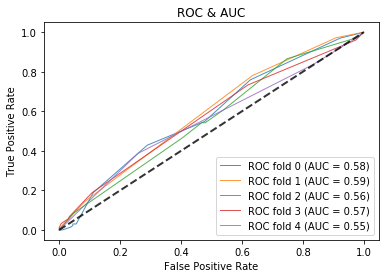

In [29]:
test_acc = []
train_acc = []

for i in range(n_folds):
#     plt.figure(figsize=(8,6))
    test_prob = riskslim_prediction(x_test_agg[i], model_information[i], subtraction_scores[i])
    train_prob = riskslim_prediction(x_train_agg[i], model_information[i], subtraction_scores[i])
    y_test, y_train = y_test_agg[i], y_train_agg[i]
    y_test[y_test == -1] = 0
    y_train[y_train == -1] = 0
    
    test_acc.append(np.mean((test_prob > 0.5) == y_test))
    train_acc.append(np.mean((train_prob > 0.5) == y_test))
    ## compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, test_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.8, 
             label = 'ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
    
plt.plot([0, 1], [0, 1], lw=2, linestyle = '--',color='black',alpha=.8)
plt.title("ROC & AUC")
plt.legend(loc = "lower right")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [31]:
test_acc

[0.5227878206371404,
 0.5335463258785943,
 0.49985199399810143,
 0.5045200525969756,
 0.5163954635108481]